<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />

# Perceptrón simple y perceptrón multicapa<a id="top"></a>

<i><small>Última actualización: 2025-02-26</small></i></div>
***

## Introducción

En el mundo del aprendizaje profundo (DL, del inglés _deep learning_), el perceptrón y el perceptrón multicapa son conceptos básicos para entender las redes neuronales. El perceptrón ([introducido por Frank Rosenblatt en 1957](https://psycnet.apa.org/doi/10.1037/h0042519)) es un modelo simple para clasificar en dos grupos. Aunque tiene limitaciones (por ejemplo, no puede resolver problemas no lineales como la puerta XOR), sienta las bases para modelos más complejos. El perceptrón multicapa agrega una o más capas ocultas, lo que permite modelar relaciones no lineales y resolver problemas más complicados.

## Objetivos

Los objetivos que trataremos de cubrir en este _notebook_ son los siguientes:

1. Explicar qué es un perceptrón y un perceptrón multicapa.
2. Describir cómo funciona cada modelo (neuronas, pesos, sesgos y funciones de activación).
3. Implementar ambos modelos desde cero usando Python y numpy.
3. Mostrar cómo usar torch para crear y entrenar redes neuronales de forma más sencilla.
4. Aplicar estos modelos a problemas prácticos (por ejemplo, clasificación de dígitos con MNIST).

## Bibliotecas y configuración

Primero, importamos las bibliotecas necesarias.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torchvision
import torchvision.transforms as transforms

Configuramos también algunos parámetros para las gráficas:

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

Por último, establecemos las constantes de los recursos comunes.

In [3]:
DATASETS_DIR = './tmp'  # Directorio donde se almacenarán los  conjuntos  de datos

***

## Perceptrón simple (Implementación desde cero con numpy)

El perceptrón simple, también conocido simplemente como perceptrón, es un modelo de aprendizaje automático lineal que se utiliza para clasificaciones binarias. Este modelo fue desarrollado en 1957 por Frank Rosenblatt y puede considerarse como la **unidad básica de una red neuronal artificial**. La idea central detrás del perceptrón es simular el funcionamiento de una neurona biológica, donde recibe múltiples señales de entrada, las procesa y produce una salida única. En términos matemáticos, el perceptrón toma un vector de características de entrada, les aplica pesos correspondientes, suma estos productos y luego aplica una función de activación, típicamente la función escalón, para determinar si la entrada pertenece a una clase o a otra. Llamaremos de ahora en adelante a este proceso **inferencia**.

El funcionamiento del perceptrón se basa en la actualización iterativa de los pesos asociados a cada característica de entrada. Durante el proceso de entrenamiento, el modelo ajusta estos pesos para minimizar el error en sus predicciones. Si la predicción es incorrecta, los pesos se actualizan en función del error cometido, utilizando una tasa de aprendizaje para controlar la magnitud del ajuste. Esta regla de aprendizaje, conocida como regla de aprendizaje del perceptrón o **regla delta**, permite al modelo aprender la frontera de decisión que mejor separa las dos clases. A pesar de su simplicidad y de estar limitado a problemas linealmente separables, el perceptrón sienta las bases para algoritmos más complejos y constituye el primer paso hacia el entendimiento de las redes neuronales multicapa y el aprendizaje profundo.

### Inferencia en el perceptrón

En la definición original del perceptrón simple, el proceso de inferencia (suma de las entradas ponderadas por sus respectivos pesos. Esta función es la función escalón, que devuelve 1 si la suma es mayor que un umbral $\mathcal{U}$ y 0 en caso contrario. Matemáticamente, la salida $\hat{y}$ de un perceptrón simple se calcula como sigue:

$$
\hat{y} = f_a(X \cdot W) = f_a\left(\sum_{i=0}^{n} x_i w_i + b\right)
$$

La matriz de pesos tendrá tantas filas como componentes tiene el vector de entrada. De hecho, podemos tener varias salidas (neuronas) diferentes, por lo que si tenemos más de una, la matriz $W$ tendrá tantas columnas como valores de salida

Este proceso se conoce como «inferencia». Vamos a implementarlo:

In [4]:
class Perceptron:
    def __init__(self, n_inputs, n_outputs):
        # W: (filas + 1 (bias), columnas)
        self.W = np.random.uniform(-0.5, 0.5, (n_inputs + 1, n_outputs))

    def activation(self, X):
        # Función de activación: función escalón
        return np.piecewise(X, [X <= 0, 0 < X], [0, 1])
        
    def inference(self, X):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        # Añadimos una columna entera de 1s (la entrada del bias)
        X = np.c_[np.ones(X.shape[0]), X]
        # Calculamos la entrada neta
        Z = X @ self.W
        # Aplicamos la función de activación
        return self.activation(Z)

Su funcionamiento sería el siguiente:

In [5]:
# Tenemos las entradas (3)
X = np.array([1, 2, 3])
# Creamos el modelo, del que obtendremos dos salidas dadas las entradas
model = Perceptron(n_inputs=3, n_outputs=2)
# Inferimos a ver qué sale
ŷ = model.inference(X)
print(ŷ)

[[0. 0.]]


Fantástico, ya tenemos un perceptrón. ¿Para qué nos vale? Realmente para nada. Los valores de los pesos se han inicializado aleatoriamente. Si queremos que de verdad de respuestas a un problema tenemos dos opciones:

1. Poner los valores de los pesos nosotros a mano (tedioso, sobre todo si la matriz de pesos es muy grande).
2. Que se pongan automáticamente de acuerdo al problema.

Evidentemente este segundo paso es el que queremos. De hecho, este paso es lo que hace que estos modelos estén dentro del área del «aprendizaje automático». La neurona va a aprender automáticamente a dar buenos resultados (o al menos lo va a intentar).

El esquema de entrenamiento será de **aprendizaje supervisado**, esto es, el modelo aprenderá a partir de un conjunto de datos en el que se encuentran tanto los valores de entrada como los valores de salida esperados a dichas entradas.

El algoritmo que usaremos será la [regla delta](https://en.wikipedia.org/wiki/Delta_rule).

### Regla delta

Disponemos de una implementación para la inferencia de un perceptrón, pero no sabemos los pesos. Para ello, vamos a introducir un algoritmo a través del cual, disponiendo de un conjunto de datos con entradas y salidas esperadas, tratará de encontrar los pesos idóneos para aproximar los valores todo lo posible a los presentados.

La regla delta calcula cómo tienen que variar los pesos actuales en función del error que se ha cometido. Esta variación obedece a las siguientes ecuaciones:

$$
\begin{align}
\Delta W       &= \alpha X^t (y - \hat{y}) \\
\Delta \vec{b} &= \alpha (y - \hat{y})
\end{align}
$$

Siendo:

- $\alpha$: El factor de aprendizaje, generalmente en el intervalo $(0, 1)$
- $X^t$: La traspuesta de las entradas.
- $y$ e $\hat{y}$: Las salidas esperada y real de la red, respectivamente.

Como se puede observar, la cantidad que variarán los pesos son directamente proporcionales al error cometido (i.e. cuanto mayor es el error más varían) y a la entrada (i.e. cuanto mayor es la entrada, más ha influido en el error).

Tras calcular esa variación, basta con sumársela a los pesos para obtener los nuevos, tal y como se expresa a continuación:

$$
\begin{align}
W_{t+1}       &= W_{t}       + \Delta W_{t+1} \\
\vec{b_{t+1}} &= \vec{b_{t}} + \Delta \vec{b_{t}}
\end{align}
$$

Vamos a implementar el cálculo de los errores en un nuevo método.

In [6]:
class Perceptron:
    def __init__(self, n_inputs, n_outputs):
        self.W = np.random.uniform(-0.5, 0.5, (n_inputs + 1, n_outputs))

    def activation(self, X):
        # Función de activación: función escalón
        return np.piecewise(X, [X <= 0, 0 < X], [0, 1])
        
    def inference(self, X):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        # Añadimos una columna entera de 1s (la entrada del bias)
        X = np.c_[np.ones(X.shape[0]), X]
        # Calculamos la entrada neta
        Z = X @ self.W
        # Aplicamos la función de activación
        return self.activation(Z)
    
    def learn(self, X, y, alpha):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        # Calculamos cuál es la salida para la entrada suministrada
        ŷ = self.inference(X)
        # Con ella, calculamos el error cometido
        error = y - ŷ
        # Añadimos una columna entera de 1s (la entrada del bias)
        X = np.c_[np.ones(X.shape[0]), X]
        # Con el error y las entradas, calculamos lo que variarán los pesos
        delta_W = alpha * X.T @ error
        # Por último, actualizamos los pesos de nuestra red
        self.W = self.W + delta_W

**NOTA**: Hay un if donde se llama a la función `expand_dims`. Esto es debido a que, cuando el vector de entrada es es un array de una dimensión, cuando se le pide las traspuesta (con `.T`) numpy nos devuelve el mismo vector, sin trasponer, por lo que antes de pedir la traspuesta nos aseguramos de que tiene al menos dos dimensiones. Esto convertiría, por ejemplo, la entrada `[0, 1]` (una dimensión) en la entrada `[[0, 1]]` (dos dimensiones).

Con este cálculo, conseguimos que los pesos se acerquen un poquito hacia valores que producen salidas con menor error. Veamos cómo se usaría:

In [7]:
# Entradas para la puera OR
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])
# Salidas esperadas para cada una de las entradas
y = np.array([[0],
              [1],
              [1],
              [1]])
# Creamos el modelo, del que obtendremos dos salidas dadas las entradas
model = Perceptron(n_inputs=2, n_outputs=1)
# Veamos sus pesos y salidas correspondientes
print(f'Pesos antes de "learn":\n {model.W}')
print(f'Salida para {X[0]}: {model.inference(X[0])} (esperada {y[0]})')
print(f'Salida para {X[1]}: {model.inference(X[1])} (esperada {y[1]})')
print(f'Salida para {X[2]}: {model.inference(X[2])} (esperada {y[2]})')
print(f'Salida para {X[3]}: {model.inference(X[3])} (esperada {y[3]})')
# Ahora, a aprender de nuestro errores
model.learn(X[0], y[0], alpha=0.5)
model.learn(X[1], y[1], alpha=0.5)
model.learn(X[2], y[2], alpha=0.5)
model.learn(X[3], y[3], alpha=0.5)
print(f'Pesos después de "learn":\n {model.W}')
print(f'Salida para {X[0]}: {model.inference(X[0])} (esperada {y[0]})')
print(f'Salida para {X[1]}: {model.inference(X[1])} (esperada {y[1]})')
print(f'Salida para {X[2]}: {model.inference(X[2])} (esperada {y[2]})')
print(f'Salida para {X[3]}: {model.inference(X[3])} (esperada {y[3]})')

Pesos antes de "learn":
 [[ 0.19081505]
 [-0.30906129]
 [ 0.22167477]]
Salida para [0 0]: [[1.]] (esperada [0])
Salida para [0 1]: [[1.]] (esperada [1])
Salida para [1 0]: [[0.]] (esperada [1])
Salida para [1 1]: [[1.]] (esperada [1])
Pesos después de "learn":
 [[0.69081505]
 [0.19093871]
 [0.72167477]]
Salida para [0 0]: [[1.]] (esperada [0])
Salida para [0 1]: [[1.]] (esperada [1])
Salida para [1 0]: [[1.]] (esperada [1])
Salida para [1 1]: [[1.]] (esperada [1])


Podemos ver que los pesos han cambiado y, a lo mejor, que las predicciones son más certeras. Un par de apuntes:

- Hemos enseñado los cuatro ejemplos de nuestro conjunto de entrenamiento (sí, se llama conjunto de entrenamiento al conjunto con el que entrenamos, en aprendizaje automático somos así de originales). A esto se le conoce como _epoch_. Los entrenamientos se miden en epochs.
- La implementación que hemos hecho permite trabajar con matrices en la entrada y salida. Esto quiere decir que el anterior _epoch se podría haber implementado así:

In [8]:
model = Perceptron(n_inputs=2, n_outputs=1)
print(f'Pesos antes de "learn":\n {model.W}')
model.learn(X, y, alpha=0.5)
print(f'Pesos después de "learn":\n {model.W}')

Pesos antes de "learn":
 [[-0.28499879]
 [ 0.4965132 ]
 [-0.22076593]]
Pesos después de "learn":
 [[0.71500121]
 [0.9965132 ]
 [0.77923407]]


Así completamos un epoch en mucho menos tiempo. De hecho, las tarjetas gráficas hacen las operaciones con matrices extremadamente rápidas, y es por ello por lo que se usan tanto en aprendizaje automático.

Y ahora que las redes saben aprender de sus errores, vamos a escribir el proceso por el cual aprenderán (o lo intentarán) todo el problema. A este proceso se le llama entrenamiento

### Entrenamiento de un perceptrón

El proceso de entrenamiento es realizar _epochs_ de aprendizaje uno detrás de otro hasta que la red haya aprendido lo que queremos que sepa hacer. O al menos hasta que lo haga «suficientemente» bien. ¡O no! porque siempre puede pasar que la red no aprenda.

Aquí vamos a usar como condición de parada un número fijo de _epochs_. Crearemos un nuevo método que llamaremos `train` que entrenará el modelo un número determinado de `epochs` sobre un conjunto de datos de entrenamiento  `X, y` y con un factor de aprendizaje `alpha`.

Aprovecharemos y añadiremos un parámetro opcional, `trace`, que indicará cada cuantos epochs nos muestra información por pantalla. Por el momento nos ceñiremos la medida de exactitud (_accuracy_) que es el número resultados acertados con respecto del total. Vamos allá

In [9]:
class Perceptron:
    def __init__(self, n_inputs, n_outputs):
        # Matriz de pesos: (filas: entradas, columnas: salidas, +1: bias)
        self.W = np.random.uniform(-0.5, 0.5, (n_inputs + 1, n_outputs))

    def activation(self, X):
        # Función de activación: función escalón
        return np.piecewise(X, [X <= 0, 0 < X], [0, 1])
        
    def inference(self, X):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        # Añadimos una columna entera de 1s (la entrada del bias)
        X = np.c_[np.ones(X.shape[0]), X]
        # Calculamos la entrada neta
        Z = X @ self.W
        # Aplicamos la función de activación
        return self.activation(Z)
    
    def learn(self, X, y, alpha):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        # Calculamos cuál es la salida para la entrada suministrada
        ŷ = self.inference(X)
        # Con ella, calculamos el error cometido
        error = y - ŷ
        # Añadimos una columna entera de 1s (la entrada del bias)
        X = np.c_[np.ones(X.shape[0]), X]
        # Con el error y las entradas, calculamos lo que variarán los pesos
        delta_W = alpha * X.T @ error
        # Por último, actualizamos los pesos de nuestra red
        self.W = self.W + delta_W
    
    def train(self, X, y, epochs, alpha, trace=1):
        for epoch in range(0, epochs):
            if epoch % trace == 0:
                print(f'Epoch {epoch}: Accuracy: {self.accuracy(X, y)}')
            self.learn(X, y, alpha)
        print(f'End -> {epochs} epochs, accuracy: {self.accuracy(X, y)}')
    
    def accuracy(self, X, y):
        ŷ = self.inference(X)
        return (y == ŷ).mean()

Ahora vamos a probar a entrenar nuestro perceptrón para una puerta AND de tres entradas 

In [10]:
DATASET_AND = np.array([
    [0, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 1, 1, 0],
    [1, 0, 0, 0],
    [1, 0, 1, 0],
    [1, 1, 0, 0],
    [1, 1, 1, 1],
])
X = DATASET_AND[:, :-1]  # Entradas: Todas las columnas hasta la última
y = DATASET_AND[:, -1:]  # Salidas: Todas las columnas desde la última

model = Perceptron(n_inputs=3, n_outputs=1)
model.train(X, y, 100, 0.1, 10)

Epoch 0: Accuracy: 0.625
Epoch 10: Accuracy: 1.0
Epoch 20: Accuracy: 1.0
Epoch 30: Accuracy: 1.0
Epoch 40: Accuracy: 1.0
Epoch 50: Accuracy: 1.0
Epoch 60: Accuracy: 1.0
Epoch 70: Accuracy: 1.0
Epoch 80: Accuracy: 1.0
Epoch 90: Accuracy: 1.0
End -> 100 epochs, accuracy: 1.0


Bueno, parece que aprende. Vamos a la principal limitación de este modelo. ¿qué pasaría si intentamos entrenar una puerta XOR?

In [11]:
DATASET_XOR = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0],
])
X = DATASET_XOR[:, :-1]  # Entradas: Todas las columnas hasta la última
y = DATASET_XOR[:, -1:]  # Salidas: Todas las columnas desde la última

model = Perceptron(n_inputs=2, n_outputs=1)
model.train(X, y, 100, 0.1, 10)

Epoch 0: Accuracy: 0.75
Epoch 10: Accuracy: 0.5
Epoch 20: Accuracy: 0.5
Epoch 30: Accuracy: 0.5
Epoch 40: Accuracy: 0.5
Epoch 50: Accuracy: 0.5
Epoch 60: Accuracy: 0.5
Epoch 70: Accuracy: 0.5
Epoch 80: Accuracy: 0.5
Epoch 90: Accuracy: 0.5
End -> 100 epochs, accuracy: 0.5


Da igual el número de _epochs_, factor de aprendizaje o parámetros que usemos. La red nunca aprenderá. La explicación es la siguiente:

**Un perceptrón es un [clasificador lineal](https://es.wikipedia.org/wiki/Clasificador_lineal)**, lo que quiere decir que clasifica basándose en la combinación lineal de las entradas. Dicho de otro modo, tiene que haber una recta en el plano (o un plano en un espacio, o ...) que separe los diferentes ejemplos a un lado y a otro.

¿Y esto qué? Bueno, el problema con la puerta XOR se ve muy fácilmente en la siguiente imagen:

<center>
<figure class="image">
    <img src="images/puertas-or-y-xor.png" alt="Representación en el plano de las puertas OR y XOR" />
    <figcaption><em><strong>Figura 1.</strong>Hay problemas muy simples que no son separables linealmente.</em></figcaption>
</figure>
</center>

Para la puerta OR es fácil encontrar una línea que separe los ejemplos cuyo valor es 1 de los ejemplos cuyo valor es 0. Para la puerta XOR es imposible. A estos problemas se los denomina, respectivamente, separables y no separables linealmente. Y el problema es que en el mundo real apenas hay problemas que sean separables linealmente, por lo que un perceptrón simple no suele ser la mejor opción casi nunca.

## Perceptrón multicapa (Implementación desde cero con numpy)

El perceptrón multicapa (MLP, del inglés _multilayer perceptron_), representa una evolución significativa del perceptrón simple hacia una arquitectura capaz de abordar la complejidad inherente a problemas no linealmente separables. A diferencia de su predecesor, el MLP incorpora una o más capas ocultas entre la capa de entrada y la capa de salida, lo que le permite modelar funciones no lineales y realizar tareas de clasificación y regresión más sofisticadas.

Cada neurona en estas capas ocultas realiza cálculos similares a los del perceptrón simple, pero la introducción de múltiples capas y la aplicación de **funciones de activación no lineales**, como la función sigmoide, ReLU o tangente hiperbólica, en cada neurona, permiten a la red aprender patrones complejos en los datos.

El entrenamiento de un perceptrón multicapa se realiza a través del algoritmo de retropropagación, un método que ajusta los pesos de la red de manera iterativa con el objetivo de minimizar la diferencia entre las salidas predichas y las salidas reales (error). Este proceso involucra el cálculo del gradiente de la función de pérdida respecto a cada peso en la red, utilizando el cálculo diferencial, y la actualización de los pesos en la dirección que reduce el error. Gracias a esta capacidad de ajuste fino y a la flexibilidad arquitectónica, los perceptrones multicapa han encontrado aplicaciones en una amplia gama de campos, desde el reconocimiento de voz y de imágenes hasta la modelización del lenguaje natural y la predicción de series temporales.

### ¿Por qué esas dos diferencias cambian tanto el comportamiento de las redes?

Las dos diferencias (varias capas y función de activación no lineal) trabajan conjuntamente para abordar el problema de la no linealidad.

Comencemos con el perceptrón de una sola capa. Aunque tengamos varias neuronas en esa capa, cada una funcionará independiente de las demás y decisión será lineal. Por tanto, por muchas neuronas que tenga, podremos dividir el espacio de entrada en muchas regiones diferentes, pero los límites de estas regiones estarán limitadas a dichos planos, por lo que podrán clasificar más de dos grupos, pero los grupos deberán ser linealmente separables.

¿Y por qué no basta con añadir más capas? ¿Por qué ese requisito de la no linealidad en las funciones de activación? Bueno, la respuesta es que una combinación lineal de funciones lineales sigue siendo una función lineal. Veámoslo con matrices que intimida más aunque es más sencillo:

Una función lineal $f_a$ tiene siempre una matriz asociada a la que llaaremos $M_a$. Ahora, recordemos la fórmula de la salida $ŷ$ de un perceptrón en función de su entrada $X$ con una activación lineal $f_a$:

$$
ŷ = f_a(X \cdot W)
$$

Si tenemos varias capas, digamos 2, la salida de una capa será la entrada de la siguiente, por lo que la función de salida quedaría como sigue:

$$
\begin{align}
S^{(1)} &= f_a(X \cdot W^{(1)}) \\
S^{(2)} &= f_a(S^{(1)} \cdot W^{(2)}) = ŷ 
\end{align}
$$

Ahora bien, dado que la función de activación $f_a$ es lineal, tiene una matriz asociada, por lo que podemos reemplazar la función con un producto de matrices:


$$
\begin{align}
ŷ &= f_a(S^{(1)} \cdot W^{(2)}) \\
  &= W_a \cdot S^{(1)} \cdot W^{(2)} \\
  &= W_a \cdot W_a \cdot X \cdot W^{(1)} W^{(2)} \\
  &= W'_a \cdot X \cdot W'^{(1)} \\
  &= f_a' (X \cdot W'^{(1)})
\end{align}
$$

Sin funciones de activación no lineales, el perceptrón multicapa no podrá aprender relaciones no lineales de los datos, básicamente tendría las mismas capacidades que una red con una sola capa. Así que si hay una relación no lineal entre la entrada y la salida, o hay interacciones entre las variables, la red no será capaz de aprenderlas.

### Inferencia en el perceptrón multicapa

La inferencia es similar a la del perceptrón simple. Lo único que variará es que, como podremos tener varias capas, la salida de cada capa será la entrada de la siguiente, por lo que lo tendremos que implementar como un bucle de inferencias capa a capa.

In [12]:
class MultilayerPerceptron:
    def __init__(self, n_inputs, n_hidden, n_outputs):
        # Matriz de pesos capa 1: (filas: entradas, columnas: salidas)
        self.W1 = np.random.uniform(-0.5, 0.5, (n_inputs, n_hidden))
        self.b1 = np.random.uniform(-0.5, 0.5, (1, n_hidden))
        # Matriz de pesos capa 2: (filas: entradas, columnas: salidas)
        self.W2 = np.random.uniform(-0.5, 0.5, (n_hidden, n_outputs))
        self.b2 = np.random.uniform(-0.5, 0.5, (1, n_outputs))

    def activation(self, X):
        # Función de activación: función sigmoidal
        return 1 / (1 + np.exp(-X))
        
    def inference(self, X):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        # Calculamos la salida de la capa 1
        S1 = self.activation(X @ self.W1 + self.b1)
        # Calculamos la salida de la capa 2
        S2 = self.activation(S1 @ self.W2 + self.b2)
        return S2

Su funcionamiento sería el siguiente:

In [13]:
# Tenemos las entradas (3)
X = np.array([1, 2, 3])
# Creamos el modelo, del que obtendremos dos salidas dadas las entradas
model = MultilayerPerceptron(n_inputs=3, n_hidden=2, n_outputs=2)
# Inferimos a ver qué sale
ŷ = model.inference(X)
print(ŷ)

[[0.37720089 0.57859697]]


Ya tenemos la inferencia programada. Ahora vamos con el algoritmo a través del que aprende la red. Ya hemos visto que la regla delta no nos vale porque para las capas ocultas no sabemos la salida esperada y, por tanto, no sabemos lo que nos estamos equivocando en ellas. Usaremos un truco, que es usar el error de las capas posteriores para estimar el error de la capa en la que nos encontramos, y usar la derivada de la función de activación para saber hacia qué punto desciende el error.

### Regla delta generalizada (_backpropagation_) y entrenamiento

Consiste en propagar desde la última capa hasta la primera el error existente entre el valor $ŷ$ que devuelve la red para la entrada $X$ y el valor de salida esperado $y$.

Lo primero que hay que hacer es calcular el error cometido en cada una de las capas para actualizar sus correspondientes pesos. La clave aquí es que hay que calcular **primero el error de la última capa**, y luego el error en las capas anteriores a partir del error inmediatamente posterior. Este error se denote como $\vec{\delta^(k)}$ y se define como sigue:

$$
\vec{\delta^{(k)}} =
  \left\{
    \begin{array}{lcc}
      &(y - ŷ) &\odot f'_a(S^(k))                              & si & k = L \\
      &\vec{\delta^{(k+1)}} \cdot W^{(k+1)T} &\odot f'_a(S^(k)) & si & k < L
    \end{array}
  \right.
$$

Tras calcular los errores de todas las capas, las matrices de cambio de pesos se definen de forma muy parecida a la regla delta, sólo que con los nuevos errores:

$$
\Delta W^{(k)} = \alpha S^{(k-1)T} \delta^{(k)}
$$

Con todos los $\Delta W^{(k)}$ calculados podemos actualizar los pesos de cada capa $k$ de la red. De esta manera habríamos realizdo un paso de aprendizaje en nuestro proceso de entrenamiento.

Ahora implementaremos tanto el algoritmo de aprendizaje como el proceso de entrenamiento en nuestro perceptrón, ya que este no cambia: al ser un esquema de aprendizaje supervisado, el principio es el mismo. Además, implementaremos un nuevo indicador del error, el RMSE, ya que al ser la función de activación una sigmoidal, jamás llegará a los valores 0 o 1.

In [14]:
class MultilayerPerceptron:
    def __init__(self, n_inputs, n_hidden, n_outputs):
        # Matriz de pesos capa 1: (filas: entradas, columnas: salidas)
        self.W1 = np.random.uniform(-0.5, 0.5, (n_inputs, n_hidden))
        self.b1 = np.random.uniform(-0.5, 0.5, (1, n_hidden))
        # Matriz de pesos capa 2: (filas: entradas, columnas: salidas)
        self.W2 = np.random.uniform(-0.5, 0.5, (n_hidden, n_outputs))
        self.b2 = np.random.uniform(-0.5, 0.5, (1, n_outputs))

    def activation(self, X):
        # Función de activación: función sigmoidal
        return 1 / (1 + np.exp(-X))
    
    def d_activation(self, X):
        # Derivada de la función de activación
        return X * (1 - X)
        
    def inference(self, X):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        # Calculamos la salida de la capa 1
        self.S1 = self.activation(X @ self.W1 + self.b1)
        # Calculamos la salida de la capa 2
        self.S2 = self.activation(self.S1 @ self.W2 + self.b2)
        return self.S2
    
    def learn(self, X, y, alpha):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        # Calculamos cuál es la salida para la entrada suministrada
        ŷ = self.inference(X)
        # Con ella, calculamos el error y la matriz de actualización de la última capa
        d2 = (y - ŷ) * self.d_activation(ŷ)
        dW2 = alpha * self.S1.T @ d2
        db2 = alpha * np.ones((1, d2.shape[0])) @ d2
        # Lo mismo pero con la primera capa
        d1 = d2 @ self.W2.T * self.d_activation(self.S1)
        dW1 = alpha * X.T @ d1
        db1 = alpha * np.ones((1, d1.shape[0])) @ d1
        # Por último, actualizamos los pesos de nuestra red
        self.W1 = self.W1 + dW1
        self.b1 = self.b1 + db1
        self.W2 = self.W2 + dW2
        self.b2 = self.b2 + db2
    
    def train(self, X, y, epochs, alpha, trace=1):
        for epoch in range(0, epochs):
            if epoch % trace == 0:
                accuracy, error = self.measures(X, y)
                print(f'Epoch {epoch}: Accuracy: {accuracy}, RMSE: {error}')
            self.learn(X, y, alpha)
        accuracy, error = self.measures(X, y)
        print(f'End -> {epoch}: Accuracy: {accuracy}, RMSE: {error}')
    
    def measures(self, X, y):
        ŷ = self.inference(X)
        accuracy = (y == ŷ).mean()
        rmse = np.sqrt(np.mean((y - ŷ)**2))
        return accuracy, rmse

Hay un detalle a la hora de actualizar los bias. Sólo hay un bias por neurona, por lo que si trabajamos con conjuntos de datos en lugar de ejemplos sueltos, hay que tenerlo en cuenta. Por eso se multiplica por un vector de 1s de la misma longitud que la de neuronas.

Ahora vamos a probar a entrenar nuestro perceptrón multicapa para una puerta OR de tres entradas 

In [15]:
DATASET_AND = np.array([
    [0, 0, 0, 0],
    [0, 0, 1, 1],
    [0, 1, 0, 1],
    [0, 1, 1, 1],
    [1, 0, 0, 1],
    [1, 0, 1, 1],
    [1, 1, 0, 1],
    [1, 1, 1, 1],
])
X = DATASET_AND[:, :-1]  # Entradas: Todas las columnas hasta la última
y = DATASET_AND[:, -1:]  # Salidas: Todas las columnas desde la última

model = MultilayerPerceptron(n_inputs=3, n_hidden=2, n_outputs=1)
model.train(X, y, 1000, 0.5, 100)

Epoch 0: Accuracy: 0.0, RMSE: 0.6097688848886329
Epoch 100: Accuracy: 0.0, RMSE: 0.3166593323331598
Epoch 200: Accuracy: 0.0, RMSE: 0.25699926606716106
Epoch 300: Accuracy: 0.0, RMSE: 0.14541674883918235
Epoch 400: Accuracy: 0.0, RMSE: 0.09100846406838356
Epoch 500: Accuracy: 0.0, RMSE: 0.06715908717757779
Epoch 600: Accuracy: 0.0, RMSE: 0.0542852663481813
Epoch 700: Accuracy: 0.0, RMSE: 0.04622165306653413
Epoch 800: Accuracy: 0.0, RMSE: 0.04066162890271334
Epoch 900: Accuracy: 0.0, RMSE: 0.03656996729676359
End -> 999: Accuracy: 0.0, RMSE: 0.03341558748761647


Veamos qué tal predice nuestro conjunto de datos de la puerta AND tras el entrenamiento

In [16]:
ŷ = model.inference(X)
np.piecewise(ŷ, [ŷ < 0.5, 0.5 <= ŷ], [0, 1])

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

Bueno, parece que aprende. Vamos a ver qué tal lo hace con la puerta XOR

In [17]:
DATASET_XOR = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0],
])
X = DATASET_XOR[:, :-1]  # Entradas: Todas las columnas hasta la última
y = DATASET_XOR[:, -1:]  # Salidas: Todas las columnas desde la última

model = MultilayerPerceptron(n_inputs=2, n_hidden=3, n_outputs=1)
model.train(X, y, 1000, 0.5, 100)
ŷ = model.inference(X)
np.piecewise(ŷ, [ŷ < 0.5, 0.5 <= ŷ], [0, 1])

Epoch 0: Accuracy: 0.0, RMSE: 0.5003982896169257
Epoch 100: Accuracy: 0.0, RMSE: 0.49994022592514803
Epoch 200: Accuracy: 0.0, RMSE: 0.4998626767218075
Epoch 300: Accuracy: 0.0, RMSE: 0.4997253304405997
Epoch 400: Accuracy: 0.0, RMSE: 0.4994365176445161
Epoch 500: Accuracy: 0.0, RMSE: 0.4987248107614073
Epoch 600: Accuracy: 0.0, RMSE: 0.49674548004426333
Epoch 700: Accuracy: 0.0, RMSE: 0.49111904070270235
Epoch 800: Accuracy: 0.0, RMSE: 0.4766754556512547
Epoch 900: Accuracy: 0.0, RMSE: 0.4508337636097519
End -> 999: Accuracy: 0.0, RMSE: 0.4214273874084714


array([[0.],
       [1.],
       [1.],
       [1.]])

¡Fantástico! ¡Parece que lo ha aprendido! Acabamos de resolver el problema que causó que durante una decada ni se hablase de redes neuronales. Hablamos de uno de los múltiples [Inviernos de la IA](https://en.wikipedia.org/wiki/AI_winter). En este en concreto, se abandonó durante algo más de una década la investigación en redes neuronales debido a las limitaciones del perceptrón.

Ahora vamos a continuar con nuestro perceptrón multicapa

### MLP con varias capas ocultas

Una pequeña vuelta de tuerca a nuestra implementación. Con una única capa oculta nos basta para aproximar cualquier función (son [aproximadores universales](https://en.wikipedia.org/wiki/Universal_approximation_theorem) de funciones), pero no son suficientes para generalizar. De hecho, más capas ocultas con menos neuronas en total suelen resolver mejor los problemas gracias a su capacidad de generalización.

Por tanto, reimplementaremos el perceptrón, esta vez para que admita un número indefinido de capas y neuronas. Concretamente, en el constructor se recibirá una lista de enteros cuyo primer valor será el número de valores de entrada, su último valor el número de neuronas de salida y los valores intermedios el número de neuronas de cada una de las capas. Por ejemplo, `layers = [2, 3, 4, 1]` se correspondería con 2 neuronas de entrada, una capa oculta de 3 neuronas, otra capa oculta de 4 neuronas y una capa de salida de una neurona.

In [18]:
class MultilayerPerceptron:
    def __init__(self, layers):
        # Los pesos de cada capa. Añadimos un elemento vacío al principio para que
        # los índices se correspondan con los de las funciones.
        self.W = [None] + [
            np.random.uniform(-0.5, 0.5, (prev_neurons, curr_neurons))
            for prev_neurons, curr_neurons in zip(layers[:-1], layers[1:])
        ]
        # Los bias de cada capa. Lo mismo que antes con el elemento vacío al ppio.
        self.b = [None] + [
            np.random.uniform(-0.5, 0.5, (1, curr_neurons))
            for curr_neurons in layers[1:]
        ]
        # La caché de salidas intermedias
        self.S = [None for _ in layers]

    def activation(self, X):
        # Función de activación: función sigmoidal
        return 1 / (1 + np.exp(-X))
    
    def d_activation(self, X):
        # Derivada de la función de activación
        return X * (1 - X)
        
    def inference(self, X):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        # La salida 0 será la entrada a la red
        self.S[0] = X
        # El resto de salidas se calculan a partir de la salida anterior
        for i in range(1, len(self.S)):
            self.S[i] = self.activation(self.S[i-1] @ self.W[i] + self.b[i])
        # La última de nuestras salidas es la salida de la red
        return self.S[-1]
    
    def learn(self, X, y, alpha):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        # Calculamos todas las salidas de nuestra red
        ŷ = self.inference(X)
        # Con ellas, vamos calculando los sucesivos errores y matrices de
        # actualización. Comenzamos por la última capa:
        δ = (y - ŷ) * self.d_activation(ŷ)
        δW = [alpha * self.S[-2].T @ δ]
        δb = [alpha * np.ones((1, δ.shape[0])) @ δ]
        # Seguimos por las capas intermedias hasta el principio de la red
        for i in range(len(self.S) - 2, 0, -1):
            δ = δ @ self.W[i+1].T * self.d_activation(self.S[i])
            δW.append(alpha * self.S[i-1].T @ δ)
            δb.append(alpha * np.ones((1, δ.shape[0])) @ δ)
        # Por último, actualizamos los pesos de nuestra red
        for i, (δW, δb) in enumerate(zip(reversed(δW), reversed(δb)), 1):
            self.W[i] = self.W[i] + δW
            self.b[i] = self.b[i] + δb
    
    def train(self, X, y, epochs, alpha, trace=1):
        for epoch in range(1, epochs):
            if epoch % trace == 0:
                accuracy, error = self.measures(X, y)
                print(f'Epoch {epoch}: Accuracy: {accuracy}, RMSE: {error}')
            self.learn(X, y, alpha)
        accuracy, error = self.measures(X, y)
        print(f'End -> {epoch}: Accuracy: {accuracy}, RMSE: {error}')
    
    def measures(self, X, y):
        ŷ = self.inference(X)
        accuracy = (y == ŷ).mean()
        rmse = np.sqrt(np.mean((y - ŷ)**2))
        return accuracy, rmse


DATASET_XOR = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0],
])
X = DATASET_XOR[:, :-1]  # Entradas: Todas las columnas hasta la última
y = DATASET_XOR[:, -1:]  # Salidas: Todas las columnas desde la última

model = MultilayerPerceptron([2, 2, 2, 1])
model.train(X, y, 10000, 0.5, 1000)
ŷ = model.inference(X)
np.piecewise(ŷ, [ŷ < 0.5, 0.5 <= ŷ], [0, 1])

Epoch 1000: Accuracy: 0.0, RMSE: 0.49998326530983717
Epoch 2000: Accuracy: 0.0, RMSE: 0.4999673248929318
Epoch 3000: Accuracy: 0.0, RMSE: 0.4999195103408866
Epoch 4000: Accuracy: 0.0, RMSE: 0.4996093288032049
Epoch 5000: Accuracy: 0.0, RMSE: 0.43973748927575107
Epoch 6000: Accuracy: 0.0, RMSE: 0.047208280743441466
Epoch 7000: Accuracy: 0.0, RMSE: 0.027682325723211405
Epoch 8000: Accuracy: 0.0, RMSE: 0.021225130025270628
Epoch 9000: Accuracy: 0.0, RMSE: 0.017776946429846632
End -> 9999: Accuracy: 0.0, RMSE: 0.015563152991723813


array([[0.],
       [1.],
       [1.],
       [0.]])

El problema del XOR tiene bastantes mínimos locales que hacen que en ocasiones el entrenamiento se quede estancado en un punto concreto. Por ello, probablemente se necesiten varias ejecuciones del entrenamiento para tener un modelo que sea capaz de clasificar esta puerta

## Implementación con PyTorch

Hasta ahora hemos implementado desde cero un perceptrón y un perceptrón multicapa. Sin embargo, existen bibliotecas de alto nivel que nos permiten crear y entrenar redes neuronales de manera más eficiente. De hecho, serán prácticamente esenciales según queramos trabajar con modelos más complejos. Una de las bibliotecas más populares para este propósito es PyTorch que, aunque no es la única, sí que es de las más usadas.

### Conjunto de datos sobre el que trabajar

Ahora estamos trabajando con modelos que aprenden bajo un esquema de aprendizaje supervisado por lo que necesitamos un conjunto de datos con entradas y sus salidas esperadas de los que aprender.

La biblioteca `torchvision` es parte de PyTorch, y entre otras cosas, nos ofrece una [colección de _datasets_ populares](https://pytorch.org/vision/stable/datasets.html) como [MNIST](https://en.wikipedia.org/wiki/MNIST_database) o [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). De ellos vamos a usar MNIST, un conjunto de 70000 imágenes (60000 en el conjunto de entrenamiento, 10000 en el conjunto de test) de dígitos escritos a mano de $28 \times 28$ píxeles junto con su correspondiente etiqueta indicando qué número es exactamente.

<center>
<figure class="image">
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" alt="Conjunto de datos MNIST" />
    <figcaption><em><strong>Figura 1.</strong>Ilustración de imágenes de ejemplo del conjunto de datos MNIST. Fuente: [Wikipedia](https://es.wikipedia.org/wiki/Base_de_datos_MNIST).</em></figcaption>
</figure>
</center>

In [19]:
# Transformación que usaremos más adelante. Convertirá PIL.Image a tensor con
#  los valores normalizados
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Obtenemos el MNIST, como objetos de la clase `torch.utils.data.Dataset`
train_set = torchvision.datasets.MNIST(
    root=DATASETS_DIR,  # Directorio donde están (o donde descargar) el dataset
    train=True,  # Las imagenes de entrenamiento
    download=True,  # En caso de que no exista, queremos descargarlo
    transform=transform,  # Para traducir las imagenes. Podíamos usar solo
                          #  `transforms.ToTensor()`, pero vamos a lo loco y
                          #  aplicamos un pipeline entero.
)
test_set = torchvision.datasets.MNIST(
    root=DATASETS_DIR,
    train=False,  # Las imágenes de test
    download=True,
    transform=transform,
)

# Creamos dataloaders para los conjuntos de datos, que nos dan una API para
#  iterar cómodamente sobre los conjuntos de datos.
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,  # El conjunto de datos sobre el que iterar
    batch_size=64,  # El número de ejemplos que recibimos en cada iteración
    shuffle=True,  # Si queremos mezclar el dataset en cada epoch
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=64,
    shuffle=False,  # Aquí no nos hace falta mezclar
)

Con los conjuntos de datos cargados y preparados, ya tenemos suficiente para trabajar. ¡Vamos allá!

### Definición del modelo

La primera forma que vamos a ver para crear modelos en PyTorch es la API secuencial. Es una forma muy sencilla donde el modelo se crea a  partir de una sucesión de capas y por debajo este las conecta (esto es, las salidas de una capa con las entradas de la siguiente). Por ejemplo, el perceptrón que implementamos anteriormente (bueno, lo más parecido a lo que podemos llegar) se implementaría como sigue:

In [20]:
model = nn.Sequential(
    nn.Linear(
        in_features=2,  # Cuantas neuronas de entrada, en nuestro caso 2
        out_features=3,  # Neuronas de salida de esta capa
    ),
    nn.Sigmoid(),  # Aplicamos sigmoide a todas las salidas (por separado)
    nn.Linear(
        in_features=3,  # El número debe igual a las salidas de la anterior
        out_features=1,  # Una única salida
    ),
    nn.Sigmoid(),  # La salida estará en el intervalo (0, 1)
)
summary(model)

/home/blazaid/Projects/aprendizaje-profundo/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            9
├─Sigmoid: 1-2                           --
├─Linear: 1-3                            4
├─Sigmoid: 1-4                           --
Total params: 13
Trainable params: 13
Non-trainable params: 0

No tiene más. Se trata de una arquitectura de dos capas, cada una con una función de activación signoidal. Para entrenar este modelo tenemos que especificar de qué manera calculamos el error (en nuestro caso antes usábamos la diferencia entre valor esperado y valor inferido) y cómo vamos a optimizar (en nuestro caso usábamos nuestra implementación del algoritmo _backpropagation_).

Ahora usaremos otra medida de eror, por ejemplo el MSE (no tiene mucho sentido, lo veremos más adelante), y otro algoritmo de optimización, el descenso del gradiente estocástico (SGD, del inglés _stochastic gradient descent_).

In [21]:
criterion = nn.MSELoss()  # Error cuadrático medio para calcular el error
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Con esto podemos entrenar el modelo. Por ejemplo, en el problema de la puerta XOR de antes:

In [22]:
DATASET_XOR = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0],
])
X = DATASET_XOR[:, :-1]  # Entradas: Todas las columnas hasta la última
y = DATASET_XOR[:, -1:]  # Salidas: Todas las columnas desde la última

# Convertimos las entradas a tensores
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Bucle de entrenamiento
num_epochs = 10000
for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()  # Reiniciamos los gradientes
    outputs = model(X_tensor)  # Propagamos la entrada hacia la salida
    loss = criterion(outputs, y_tensor)  # Calculamos el error en la predicción
    loss.backward()  # Retropropagamos el error para determinar los gradientes
    optimizer.step()  # Actualizamos los pesos

    # Mostrar información cada 1000 épocas
    if (epoch + 1) % (num_epochs // 10) == 0:
        with torch.no_grad():  # Cuando solo predecimos y no vamos a entrenar,
                               #  desactivamos los gradientes.
            predictions = (outputs >= 0.5).float()  # será 0 si < 0.5, si no 1
            accuracy = (predictions == y_tensor).float().mean()
        print(f"Epoch [{epoch}/{num_epochs}]")
        print(f"- Loss: {loss.item():.4f}")
        print(f"- Accuracy: {accuracy.item()*100:.2f}%")

Epoch [999/10000]
- Loss: 0.2492
- Accuracy: 50.00%
Epoch [1999/10000]
- Loss: 0.2481
- Accuracy: 50.00%
Epoch [2999/10000]
- Loss: 0.2446
- Accuracy: 75.00%
Epoch [3999/10000]
- Loss: 0.2339
- Accuracy: 75.00%
Epoch [4999/10000]
- Loss: 0.2081
- Accuracy: 75.00%
Epoch [5999/10000]
- Loss: 0.1687
- Accuracy: 75.00%
Epoch [6999/10000]
- Loss: 0.1120
- Accuracy: 100.00%
Epoch [7999/10000]
- Loss: 0.0561
- Accuracy: 100.00%
Epoch [8999/10000]
- Loss: 0.0288
- Accuracy: 100.00%
Epoch [9999/10000]
- Loss: 0.0173
- Accuracy: 100.00%


Ahora evaluamos el resultado. ara un problema es matar moscas a cañonazos, pero nos permite entender todo el proceso.

In [23]:
with torch.no_grad():  # Solo predecir, no queremos los gradientes para nada
    outputs = model(X_tensor)
    predictions = (outputs >= 0.5).float()
    accuracy = (predictions == y_tensor).float().mean()
    print("Final predictions:")
    print(predictions)
    print(f"Final accuracy: {accuracy.item()*100:.2f}%")

Final predictions:
tensor([[0.],
        [1.],
        [1.],
        [0.]])
Final accuracy: 100.00%


Ahora bien, con el conjunto de datos de `mnist` tenemos que hacer algunos cambios porque este modelo no nos vale:

1. La entrada es una matriz de $28 \times 28$, y hasta ahora hemos visto modelos que esperan un vector de entrada. Afortunadamente para esto último PyTorch nos proporciona una capa denominada `Flatten`, que simplifica nuestros datos «aplanando» la información de la estructura 2D de la imagen  en un único vector de una dimensión.
2. Una imagen no es una puerta OR. Mejor aumentamos un poco el tamaño de la capa oculta.
3. La salida de nuestro modelo no es $0$ o $1$. Es un valor de $0$ a $9$. Si fuese una clasificación binaria valdría, pero es una clasificación denominada «multiclase» (solo una clase es válida para una entrada concreta). Para estos casos, se suele trabajar con varias clasificaciones binarias, una para cada clase. Como tenemos $10$ posibles valores de salida, usaremos $10$ neuronas, una para cada clase. En otros _frameworks_, para problemas de clasificación multiclase se usan aquí dos funciones por separado, **activación final**, que suele ser una función _softmax_ o _log-softmax_, **y error** o «pérdida» (del inglés _loss_), que suele ser la entropía cruzada (del inglés _cross entropy_. Sin embargo, en PyTorch la función de _loss_ para la entropía cruzada ya lleva incorporada la capa de activación _log-softmax_ así que no hace falta añadirla.

Con estos cambios nuestro modelo quedaría como sigue:

In [24]:
model = nn.Sequential(
    nn.Flatten(),  # Pasamos de un  tensor (28, 28) a uno (784,)
    nn.Linear(in_features=28*28, out_features=32),  # 28*28 = 784 entradas
    nn.Sigmoid(),  # Aplicamos sigmoide a todas las salidas (por separado)
    nn.Linear(in_features=32, out_features=10),  # 10 clases, de la 0 a la 9.
)

criterion = nn.CrossEntropyLoss()  # La función de error para la clasificación
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            25,120
├─Sigmoid: 1-3                           --
├─Linear: 1-4                            330
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0

Es curioso ver cómo se ha disparado el número de parámetros con solo aumentar un poco el número de neuronas. Bueno, veamos qué tal se comporta con el conjunto de entrenamiento de `mnist`.

In [25]:
history = {'loss': [], 'accuracy': []}

num_epochs = 20
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:  # Usamos todas las imágenes cada epoch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()  # Acumulamos todos los loss para el total
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)  # Número de imagenes procesadas este batch
        correct += (predicted == labels).sum().item()  # Número de aciertos

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)

    print(f"Epoch {epoch} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1 - Loss: 0.7448, Accuracy: 0.8223
Epoch 2 - Loss: 0.3193, Accuracy: 0.9110
Epoch 3 - Loss: 0.2665, Accuracy: 0.9244
Epoch 4 - Loss: 0.2373, Accuracy: 0.9316
Epoch 5 - Loss: 0.2169, Accuracy: 0.9376
Epoch 6 - Loss: 0.2014, Accuracy: 0.9427
Epoch 7 - Loss: 0.1893, Accuracy: 0.9455
Epoch 8 - Loss: 0.1789, Accuracy: 0.9492
Epoch 9 - Loss: 0.1706, Accuracy: 0.9516
Epoch 10 - Loss: 0.1631, Accuracy: 0.9531
Epoch 11 - Loss: 0.1559, Accuracy: 0.9553
Epoch 12 - Loss: 0.1505, Accuracy: 0.9567
Epoch 13 - Loss: 0.1456, Accuracy: 0.9582
Epoch 14 - Loss: 0.1402, Accuracy: 0.9598
Epoch 15 - Loss: 0.1360, Accuracy: 0.9612
Epoch 16 - Loss: 0.1315, Accuracy: 0.9621
Epoch 17 - Loss: 0.1276, Accuracy: 0.9633
Epoch 18 - Loss: 0.1243, Accuracy: 0.9648
Epoch 19 - Loss: 0.1212, Accuracy: 0.9663
Epoch 20 - Loss: 0.1179, Accuracy: 0.9660


Esto ya ha tardado  más, ¿eh? Claro, son bastantes imágenes, es normal.

Hemos guardado en el diccionario history un histórico de todos los indicadores de nuestro proceso de entrenamiento (incluidas las métricas especificadas en el método `compile`) _epoch_ por _epoch_. Podemos aprovechar este objeto para imprimir por pantalla la evolución del entrenamiento, lo que nos daría información acerca de cómo ha ido:

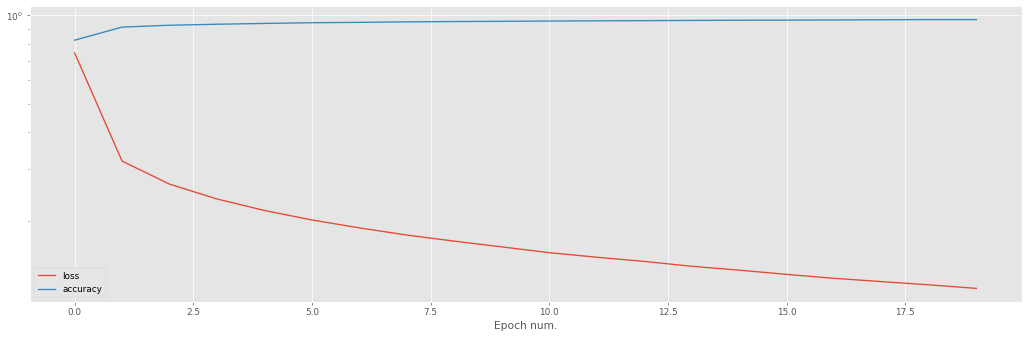

In [26]:
pd.DataFrame(history).plot()
plt.xlabel('Epoch num.')
plt.yscale('log')
plt.show()

Esta gráfica nos dice más o menos tres cosas:

1. El error (_loss_) va bajando durante el entrenamiento; eso es bueno.
2. La exactitud (_accuracy_) va subiendo; suele venir de la mano con la bajada del _loss_, así que también es bueno.

A la vista de los resultados, parece que el modelo acierta más o menos un $97,5\%$ de los casos. Ya veremos más adelante detalles sobre el entrenamiento y por qué son interesantes los conjuntos de validación. Lo importante ahora es que, si damos como bueno este modelo, el siguienter (y último) paso para determinar si es apto para usarse en el mundo real sería comprobar con el conjunto de test. Veamos cómo se comporta con este.

In [27]:
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test accuracy: {100 * correct / total:.2f}%")

Test accuracy: 96.05%


¡Aproximadamente un 97% de exactitud! La verdad es que no está mal. O sí, no sé, la verdad es que depende del problema. Aquí nos está diciendo que de $10000$ imágenes hay $300$ que no ha clasificado bien. Parece que un $3\%$ de error está bastante bien en un problema de reconocimiento de imágenes, pero a lo mejor en un problema de reconocer un cáncer de mama no es una estadística muy halagüeña.

Pero no nos preocupemos, hay más modelos que aprenderemos para abordar diferentes casos que nos ayudarán en multitud de tareas. Lo importante es ir llenando nuestra caja de herramientas de técnicas y de intuiciones de cómo y cuándo usarlas.

***

## Conclusiones

En este _notebook_ hemos recorrido lo más básico del aprendizaje profundo. Con el perceptrón simple vimos cómo funciona un modelo lineal básico y entendimos sus limitaciones frente a problemas complejos. Luego, al estudiar el perceptrón multicapa, observamos que añadir capas ocultas **y usar funciones de activación no lineales** permite resolver problemas que los modelos lineales no pueden.

La implementación desde cero nos ayudó a comprender el proceso de aprendizaje y la actualización de pesos, mientras que el uso de PyTorch demuestra que se pueden construir y entrenar redes neuronales de forma mucho más sencilla. De ahora en adelante comenzaremos a ver temas más interesantes, pero con la base ya asentada.

***

## Referencias

[1] Guía para la creación de capas y modelos personalizados (<https://www.tensorflow.org/guide/keras/custom_layers_and_models>)

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>